# Training a custom Text Summarization Model

- Dependencies to be installed

In [1]:
#!pip install GPUtil
# !pip install transformers
#! pip install git-lfs

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=c754e2f657c825bfa69f8b5fb83812d6c305e302005bfea16b707c4d500e7af6
  Stored in directory: /home/aakash/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built GPUtil


- GPUtil is a Python module for getting the GPU status from NVIDA GPUs using nvidia-smi.

In [1]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()     

| ID | GPU | MEM |
------------------
|  0 |  5% | 10% |


In [2]:
import torch
print(torch.__version__)

1.10.1


In [3]:
torch.cuda.is_available()
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

11.3
NVIDIA GeForce GTX 1650 Ti


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the dataset
- We'll be using the SAMSum dataset (developed by Samsung), which consists of a collection of dialogues along with brief summaries.

In [6]:
from datasets import load_dataset
samsum = load_dataset('samsum')

Reusing dataset samsum (/home/aakash/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [8]:
print(f"Features : {samsum['train'].column_names}")

Features : ['id', 'dialogue', 'summary']


- Let's us check the dialogue and its summary given in the SAMSUM dataset

In [9]:
print("Dialogue: \n")
print(samsum['train'][0]['dialogue'])

Dialogue: 

Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)


In [10]:
print("Summary: \n")
print(samsum['train'][0]['summary'])

Summary: 

Amanda baked cookies and will bring Jerry some tomorrow.


# ------------------------------------------------------------------------------

# T5 (Text to Text Transfer Transformer) Model
- T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format.
- T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task.

In [11]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

#### Checking the length distribution of dialogue and summary

In [12]:
d_len = [len(tokenizer.encode(text)) for text in samsum['train']['dialogue']]
s_len = [len(tokenizer.encode(text)) for text in samsum['train']['summary']]

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


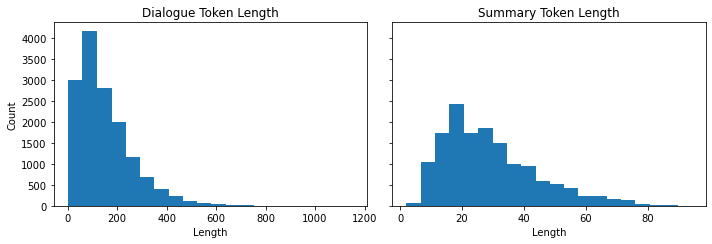

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()


- Most of our dialogue lengths are between 100-200 tokens per dialogue and summary lenth is between 20-40 tokens per dialogue.

In [14]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()             

| ID | GPU | MEM |
------------------
|  0 | 64% | 10% |


# ------------------------------------------------------------------------------------------

### Let us tokenize the dataset
- We’ll set the maximum lengths to 1024 for the dialogues and 128 for the summaries

In [15]:
def convert_examples_to_features(example_batch):
    
    input_encodings = tokenizer(example_batch["dialogue"],
                                max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"],
                                     max_length=128,
                                     truncation=True)
        
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}


In [16]:
dataset_samsum_pt = samsum.map(convert_examples_to_features, 
                               batched=True)

columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

### Create Data Collator
- This function is called in the Trainer. 

In [17]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

### Setting up TrainingArguments for training

In [18]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments('t5-small-samsum',
                                  num_train_epochs=1, 
                                  warmup_steps=500,
                                  per_device_train_batch_size=1, 
                                  per_device_eval_batch_size=1,
                                  weight_decay=0.01,
                                  logging_steps=10, 
                                  push_to_hub=True,
                                  push_to_hub_model_id='t5-small-samsum',  
                                  evaluation_strategy='steps',
                                  eval_steps=500,
                                  save_steps=1e6,
                                  gradient_accumulation_steps=16
                                 )

ValueError: You need to pass a valid `token` or login by using `huggingface-cli login`

- Logging into HuggingFace so that we can push our model to the Hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer = Trainer(model = model, 
                  args = training_args,
                  tokenizer = tokenizer,
                  data_collator = seq2seq_data_collator,
                  train_dataset = dataset_samsum_pt["train"],
                  eval_dataset = dataset_samsum_pt["validation"]
                 )

In [ ]:
trainer.train()

- Pusing our model to the hub so that we can easily use it

In [ ]:
trainer.push_to_hub("Training finally completed!!!!!!")

# -------------------------------------------------------------------------------------------

## Testing our model on random conversation

In [1]:
conversation = '''
Aakash: Do you watched last night match?
Vikas: No, I was busy. What happended?
Aakash: Barcelona won their game against Sevilla 1-0. Pedri scored an sensational goal.
Vikas: Oh really!!! I have to watch the highlights at home.
Aakash: Yes, I am so excited for the new upcoming season. Xavi really doing wonders.
Vikas: Exactly!! Xavi has changed the way Barcelona play. The good days are coming back. 
'''

In [2]:
from transformers import pipeline

In [3]:
summarizer = pipeline('summarization', model='anegi/t5-small-samsum')

Exception: No such file or directory (os error 2)

In [49]:
summarizer(conversation, max_length=90, min_length = 35)

[{'summary_text': 'Pedri scored a sensational goal for Barcelona against Sevilla . Xavi has changed the way they play. Aakash is excited for the new season.'}]

# -----------------------------------------------------------------------------------------

## Rogue - Score
#### Method 1

In [50]:
from rouge_score import rouge_scorer

In [51]:
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL','rougeLsum'],
                                  use_stemmer=True)
# Adding a summary that a human would generate when the above conversation is provided to them.

scores = scorer.score(conversation,
                      'Aakash asked Vikas about the match which Barcelona won where Pedri scored the only goal.')

In [52]:
scores

{'rouge1': Score(precision=0.6666666666666666, recall=0.14492753623188406, fmeasure=0.2380952380952381),
 'rouge2': Score(precision=0.14285714285714285, recall=0.029411764705882353, fmeasure=0.04878048780487805),
 'rougeL': Score(precision=0.4666666666666667, recall=0.10144927536231885, fmeasure=0.16666666666666669),
 'rougeLsum': Score(precision=0.6666666666666666, recall=0.14492753623188406, fmeasure=0.2380952380952381)}

- Converting the scores to dataframe

In [53]:
df_score = pd.DataFrame(scores)

In [54]:
df_score.index = ['precision','recall','fmeasure']

In [55]:
df_score

,rouge1,rouge2,rougeL,rougeLsum
precision,0.666667,0.142857,0.466667,0.666667
recall,0.144928,0.029412,0.101449,0.144928
fmeasure,0.238095,0.048780,0.166667,0.238095


# -----------------------------------------------------------------------------------------

#### Method 2

- The ROUGE metric in the HuggingFace Datasets library also calculates confidence intervals
  ( by default, the 5th and 95th percentiles). The average value is stored in the attribute mid and
   the interval can be retrieved with low and high.

In [64]:
from datasets import load_metric
rougue_metric = load_metric('rouge')

In [65]:
rougue_metric.add(prediction = 'Aakash asked Vikas about the match which Barcelona won where Pedri scored the only goal.',
                  reference = [conversation])

In [66]:
score2 = rougue_metric.compute()

In [88]:
score2

{'rouge1': AggregateScore(low=Score(precision=0.5333333333333333, recall=0.11428571428571428, fmeasure=0.18823529411764706), mid=Score(precision=0.5333333333333333, recall=0.11428571428571428, fmeasure=0.18823529411764706), high=Score(precision=0.5333333333333333, recall=0.11428571428571428, fmeasure=0.18823529411764706)),
 'rouge2': AggregateScore(low=Score(precision=0.14285714285714285, recall=0.028985507246376812, fmeasure=0.048192771084337345), mid=Score(precision=0.14285714285714285, recall=0.028985507246376812, fmeasure=0.048192771084337345), high=Score(precision=0.14285714285714285, recall=0.028985507246376812, fmeasure=0.048192771084337345)),
 'rougeL': AggregateScore(low=Score(precision=0.4, recall=0.08571428571428572, fmeasure=0.1411764705882353), mid=Score(precision=0.4, recall=0.08571428571428572, fmeasure=0.1411764705882353), high=Score(precision=0.4, recall=0.08571428571428572, fmeasure=0.1411764705882353)),
 'rougeLsum': AggregateScore(low=Score(precision=0.4, recall=0.0

- Converting the scores into dataframe

In [94]:
df = pd.DataFrame.from_dict(score2, orient="index").stack().to_frame()

# to break out the lists into columns

df_score2 = pd.DataFrame(df[0].values.tolist(), index=df.index)

In [95]:
df_score2

precision    recall  fmeasure
rouge1    low    0.533333  0.114286  0.188235
          mid    0.533333  0.114286  0.188235
          high   0.533333  0.114286  0.188235
rouge2    low    0.142857  0.028986  0.048193
          mid    0.142857  0.028986  0.048193
          high   0.142857  0.028986  0.048193
rougeL    low    0.400000  0.085714  0.141176
          mid    0.400000  0.085714  0.141176
          high   0.400000  0.085714  0.141176
rougeLsum low    0.400000  0.085714  0.141176
          mid    0.400000  0.085714  0.141176
          high   0.400000  0.085714  0.141176

# -------------------------------------------------------------------------------------------------------------